In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
%ls

all_data_wk4.csv     previous_xgb.csv          test.csv
all_ones.csv         sales_train.csv.gz        test.csv.gz
EDA_1st_week.ipynb   sales_train_v2.csv        test_to_daily.ipynb
ideas.txt            sample_submission.csv     XGBreg_daily.ipynb
item_categories.csv  sample_submission.csv.gz  XGBreg_monthly.ipynb
items.csv            shops.csv                 X_train_wk4.csv
previous_values.csv  submission.csv


In [4]:
items = pd.read_csv('items.csv')
cat_id = items[['item_id', 'item_category_id']]
train = train.merge(cat_id, on='item_id', how='left')
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
5,10.01.2013,0,25,2564,349.00,1.0,59
6,02.01.2013,0,25,2565,549.00,1.0,56
7,04.01.2013,0,25,2572,239.00,1.0,55
8,11.01.2013,0,25,2572,299.00,1.0,55
9,03.01.2013,0,25,2573,299.00,3.0,55


In [5]:
# Let's add year, month, day, day of week, day of month, week of year
train['date_'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
print(train['date_'].min())
print(train['date_'].max())

2013-01-01 00:00:00
2015-10-31 00:00:00


In [6]:
# Ok, so we need to predict sales for each product of each shop for November 2015.
# Adding features about time of year, week...
# Try to visualize some seasonality?
train['year'] = train['date_'].dt.year
train['month'] = train['date_'].dt.month
train['day'] = train['date_'].dt.day
train['week'] = train['date_'].dt.week
train['week_day'] = train['date_'].dt.weekday
train['year_day'] = train['date_'].dt.dayofyear

In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,day,week,week_day,year_day
0,02.01.2013,0,59,22154,999.00,1.0,37,2013-01-02,2013,1,2,1,2,2
1,03.01.2013,0,25,2552,899.00,1.0,58,2013-01-03,2013,1,3,1,3,3
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013-01-05,2013,1,5,1,5,5
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013-01-06,2013,1,6,1,6,6
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013-01-15,2013,1,15,3,1,15


In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,day,week,week_day,year_day
0,02.01.2013,0,59,22154,999.00,1.0,37,2013-01-02,2013,1,2,1,2,2
1,03.01.2013,0,25,2552,899.00,1.0,58,2013-01-03,2013,1,3,1,3,3
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013-01-05,2013,1,5,1,5,5
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013-01-06,2013,1,6,1,6,6
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013-01-15,2013,1,15,3,1,15


In [9]:
prev_monthly = (train[['shop_id', 'item_id', 'year', 'month', 'item_cnt_day', 'item_price']]
                .groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False)
                .agg({'item_cnt_day': 'sum', 'item_price': ['mean', 'min', 'max']})
               )
# prev_monthly['month'] = prev_monthly['month'] + 1
# shifted2 = prev_monthly.copy()
for shift in [1, 2, 6, 12]:
    shifted = prev_monthly.copy()
    shifted['month'] = shifted['month'] + shift
    shifted = shifted.rename(columns={'item_cnt_day': 'item_cnt_' + str(shift), 'item_price': 'item_price_'+ str(shift)}) 
    shifted.columns = [col[0] if col[-1]=='' else col[0] + '_' + col[-1] for col in shifted.columns.values]    
    train = pd.merge(train, shifted, on=['shop_id', 'item_id', 'year', 'month'], how='left')
#     print(shifted.tail())
#     print(train.tail())
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,...,item_price_2_min,item_price_2_max,item_cnt_6_sum,item_price_6_mean,item_price_6_min,item_price_6_max,item_cnt_12_sum,item_price_12_mean,item_price_12_min,item_price_12_max
0,02.01.2013,0,59,22154,999.00,1.0,37,2013-01-02,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,03.01.2013,0,25,2552,899.00,1.0,58,2013-01-03,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013-01-05,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013-01-06,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013-01-15,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# # Add previous month item count as a feature
# prev_monthly.rename(columns={'item_cnt_day': 'previous_month_cnt',
#                             'item_price': 'previous_item_price'}, inplace=True)
# prev_monthly.columns = [col[0] if col[-1]=='' else col[-1] for col in prev_monthly.columns.values]
# prev_monthly.loc[prev_monthly.month == 13, 'year'] += 1
# prev_monthly.loc[prev_monthly.month == 13, 'month'] = 1
# prev_monthly.head()

In [11]:
# Total shop lagged
prev_shop = train[['shop_id', 'year', 'month', 'item_cnt_day']].groupby(['shop_id', 'year', 'month'], as_index=False).agg({'item_cnt_day':['sum','mean']})
prev_shop['month'] = prev_monthly['month'] + 1
prev_shop.rename(columns={'item_cnt_day': 'previous_shop_cnt'}, inplace=True)
prev_shop.columns = [col[0] if col[-1]=='' else col[-1] for col in prev_shop.columns.values]
prev_shop.loc[prev_shop.month == 13, 'year'] += 1
prev_shop.loc[prev_shop.month == 13, 'month'] = 1
prev_shop.head()

,shop_id,year,month,sum,mean
0,0,2013,3,5578.0,1.163781
1,0,2013,3,6127.0,1.209913
2,1,2013,2,2947.0,1.093912
3,1,2013,3,3364.0,1.127346
4,2,2013,2,1146.0,1.070028


In [12]:
# Total item lagged
prev_item = train[['item_id', 'year', 'month', 'item_cnt_day']].groupby(['item_id', 'year', 'month'], as_index=False).agg({'item_cnt_day':['sum', 'mean']})
prev_item.rename(columns={'item_cnt_day': 'previous_item_cnt'}, inplace=True)
prev_item.columns = [col[0] if col[-1]=='' else col[-1] for col in prev_item.columns.values]
prev_item.loc[prev_item.month == 13, 'year'] += 1
prev_item.loc[prev_item.month == 13, 'month'] = 1
prev_item.head()

,item_id,year,month,sum,mean
0,0,2014,9,1.0,1.0
1,1,2014,4,2.0,1.0
2,1,2014,7,1.0,1.0
3,1,2014,8,1.0,1.0
4,1,2014,9,1.0,1.0


In [13]:
# train = train.merge(prev_monthly, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train = train.merge(prev_shop, on=['shop_id', 'year', 'month'], how='left')
train = train.merge(prev_item, on=['item_id', 'year', 'month'], how='left')

train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,...,item_price_6_min,item_price_6_max,item_cnt_12_sum,item_price_12_mean,item_price_12_min,item_price_12_max,sum_x,mean_x,sum_y,mean_y
5433928,10.10.2015,33,25,7409,299.0,1.0,55,2015-10-10,2015,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0
5433929,09.10.2015,33,25,7460,299.0,1.0,55,2015-10-09,2015,10,...,299.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1.0
5433930,14.10.2015,33,25,7459,349.0,1.0,55,2015-10-14,2015,10,...,349.0,349.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0
5433931,22.10.2015,33,25,7440,299.0,1.0,57,2015-10-22,2015,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
5433932,03.10.2015,33,25,7460,299.0,1.0,55,2015-10-03,2015,10,...,299.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1.0


In [14]:
train = train.fillna(0)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,...,item_price_6_min,item_price_6_max,item_cnt_12_sum,item_price_12_mean,item_price_12_min,item_price_12_max,sum_x,mean_x,sum_y,mean_y
0,02.01.2013,0,59,22154,999.00,1.0,37,2013-01-02,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0
1,03.01.2013,0,25,2552,899.00,1.0,58,2013-01-03,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013-01-05,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013-01-06,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013-01-15,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [15]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [16]:
train = downcast_dtypes(train)


In [17]:
# Validation on last month of training
train_xgb = train[train['date_block_num'].isin(range(1,33))]
val = train[train['date_block_num'] == 33]
train_xgb.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_,year,month,...,item_price_6_min,item_price_6_max,item_cnt_12_sum,item_price_12_mean,item_price_12_min,item_price_12_max,sum_x,mean_x,sum_y,mean_y
5380414,27.09.2015,32,25,21022,1799.0,1.0,61,2015-09-27,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.00
5380415,19.09.2015,32,25,21105,1799.0,1.0,61,2015-09-19,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
5380416,30.09.2015,32,25,21088,1299.0,1.0,61,2015-09-30,2015,9,...,1299.0,1299.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.00
5380417,08.09.2015,32,25,20990,1299.0,1.0,61,2015-09-08,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.00
5380418,25.09.2015,32,25,20303,399.0,1.0,40,2015-09-25,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,1.09


In [18]:
# Dropping non features columns and targets
train_xgb = train_xgb.drop(['date', 'date_', 'item_price', 'date_block_num'], axis=1)
val_targets = val[['item_cnt_day']]
val = val.drop(['date', 'date_', 'item_price', 'date_block_num', 'item_cnt_day'], axis=1)

In [19]:
val_train_targets = train[train['date_block_num'] == 32][['item_cnt_day']]
val_train = train[train['date_block_num'] == 32].drop(['date', 'date_', 'item_price', 'date_block_num', 'item_cnt_day'], axis= 1)

In [20]:
train_xgb.head()

,shop_id,item_id,item_cnt_day,item_category_id,year,month,day,week,week_day,year_day,...,item_price_6_min,item_price_6_max,item_cnt_12_sum,item_price_12_mean,item_price_12_min,item_price_12_max,sum_x,mean_x,sum_y,mean_y
115690,50,3880,1.0,23,2013,2,21,8,3,52,...,0.0,0.0,0.0,0.0,0.0,0.0,3054.0,1.156818,46.0,1.045455
115691,50,3880,1.0,23,2013,2,21,8,3,52,...,0.0,0.0,0.0,0.0,0.0,0.0,2839.0,1.105099,46.0,1.045455
115692,50,3880,1.0,23,2013,2,21,8,3,52,...,0.0,0.0,0.0,0.0,0.0,0.0,3235.0,1.126785,46.0,1.045455
115693,50,3880,1.0,23,2013,2,21,8,3,52,...,0.0,0.0,0.0,0.0,0.0,0.0,3655.0,1.328608,46.0,1.045455
115694,50,3880,1.0,23,2013,2,21,8,3,52,...,0.0,0.0,0.0,0.0,0.0,0.0,3554.0,1.272011,46.0,1.045455


In [21]:
import xgboost as xgb
reg_model = xgb.XGBRegressor(learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=200, n_jobs=-1, shuffle=False)
reg_model.fit(train_xgb.drop(['item_cnt_day'], axis=1), train_xgb[['item_cnt_day']])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       shuffle=False, silent=True, subsample=1)

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
preds = reg_model.predict(val).clip(0,20)
print('rmse: ' + str(np.sqrt(mean_squared_error(val_targets, preds))))
print('r2: ' + str( r2_score(reg_model.predict(train_xgb.drop(['item_cnt_day'], axis=1)), train_xgb[['item_cnt_day']])))

# rmse: 9.98322379736
# r2: -4.18305659792
# rmse: 9.26527702121
# r2: -3.75758768068
# rmse: 9.72299
# r2: -0.0361208895691
# rmse: 9.63879
# r2: 0.454858565409



rmse: 9.64186


MemoryError: 

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit((train_xgb.drop(['item_cnt_day'], axis=1)).values, train_xgb[['item_cnt_day']].values)
pred_lr = lr.predict(val.values)

print('Test R-squared for linreg is %f' % r2_score(val_targets.values, pred_lr))
# Test R-squared for linreg is 0.008716
# Test R-squared for linreg is 0.011675
# Test R-squared for linreg is 0.058861
# Test R-squared for linreg is 0.058637

In [23]:
val_train_targets = train[train['date_block_num'] == 32][['item_cnt_day']]
val_train = train[train['date_block_num'] == 32].drop(['date', 'date_', 'item_price', 'date_block_num', 'item_cnt_day'], axis= 1)
train_preds = reg_model.predict(val_train).clip(0,20)
print('rmse: ' + str(np.sqrt(mean_squared_error(val_train_targets, train_preds))))

rmse: 5.64081


In [38]:
all_data_wk_4 = pd.read_csv('all_data_wk4.csv')
last_block = 33
dates = all_data_wk_4['date_block_num']

In [44]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data_wk_4.loc[dates <  last_block].drop(['date_block_num', 'target'], axis=1)
X_test =  all_data_wk_4.loc[dates == last_block].drop(['date_block_num', 'target'], axis=1)

y_train = all_data_wk_4.loc[dates <  last_block, 'target'].values
y_test =  all_data_wk_4.loc[dates == last_block, 'target'].values

In [45]:
train.shape

(5433933, 33)

In [46]:
lr.fit(X_train.values, y_train)
pred_lr_wk4 = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr_wk4))

Test R-squared for linreg is 0.860935


In [47]:
reg_model.fit(X_train, y_train)
preds_wk4 = reg_model.predict(X_test).clip(0,20)
print('rmse: ' + str(np.sqrt(mean_squared_error(y_test, preds_wk4))))
# print('r2: ' + str( r2_score(reg_model.predict(train_xgb.drop(['item_cnt_day'], axis=1)), train_xgb[['item_cnt_day']])))


rmse: 4.03537594298


In [ ]:
#-------------------------------- Prepare test set as a daily dataset

In [11]:
# Add mean item price from previous month as feature
mean_price = train[['shop_id', 'item_id', 'year', 'month', 'item_price']].groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False).mean()
mean_price.loc[mean_price.month == 13, 'year'] += 1
mean_price.loc[mean_price.month == 13, 'month'] = 1
mean_price.rename(columns={'item_price': 'prev_mean_item_price'}, inplace=True)

In [12]:
train_monthly = train_monthly.merge(mean_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt,prev_mean_item_price
0,0,30,2013,2,31.0,0.0,265.0
1,0,31,2013,2,11.0,0.0,434.0
2,0,32,2013,1,6.0,0.0,221.0
3,0,32,2013,2,10.0,6.0,221.0
4,0,33,2013,1,3.0,0.0,347.0


In [13]:
# Add min item price from previous month as feature
min_price = train[['shop_id', 'item_id', 'year', 'month', 'item_price']].groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False).min()
min_price.loc[min_price.month == 13, 'year'] += 1
min_price.loc[min_price.month == 13, 'month'] = 1
min_price.rename(columns={'item_price': 'prev_min_item_price'}, inplace=True)
train_monthly = train_monthly.merge(min_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt,prev_mean_item_price,prev_min_item_price
0,0,30,2013,2,31.0,0.0,265.0,265.0
1,0,31,2013,2,11.0,0.0,434.0,434.0
2,0,32,2013,1,6.0,0.0,221.0,221.0
3,0,32,2013,2,10.0,6.0,221.0,221.0
4,0,33,2013,1,3.0,0.0,347.0,347.0


In [14]:
# Add max item price from previous month as feature
max_price = train[['shop_id', 'item_id', 'year', 'month', 'item_price']].groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False).max()
max_price.loc[max_price.month == 13, 'year'] += 1
max_price.loc[max_price.month == 13, 'month'] = 1
max_price.rename(columns={'item_price': 'prev_max_item_price'}, inplace=True)
train_monthly = train_monthly.merge(max_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt,prev_mean_item_price,prev_min_item_price,prev_max_item_price
0,0,30,2013,2,31.0,0.0,265.0,265.0,265.0
1,0,31,2013,2,11.0,0.0,434.0,434.0,434.0
2,0,32,2013,1,6.0,0.0,221.0,221.0,221.0
3,0,32,2013,2,10.0,6.0,221.0,221.0,221.0
4,0,33,2013,1,3.0,0.0,347.0,347.0,347.0


In [15]:
train_monthly['prev_min_item_price'] = train_monthly['prev_min_item_price'].fillna(train_monthly['prev_min_item_price'].mean())
train_monthly['prev_max_item_price'] = train_monthly['prev_max_item_price'].fillna(train_monthly['prev_max_item_price'].mean())

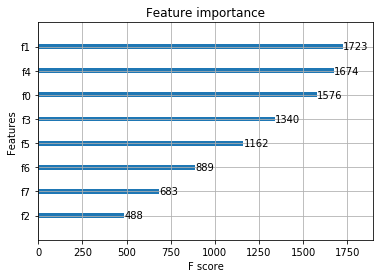

In [16]:
# Exploring features importance
import xgboost as xgb
dtrain = xgb.DMatrix(train_monthly.drop(['item_cnt_month'], axis=1).values, train_monthly[['item_cnt_month']].values)
param = {'max_depth':10, 'eta':0.05, 'silent':0, 'objective':'reg:linear' }
num_round = 25
xgb_feat = xgb.train(param, dtrain, num_round)
xgb.plot_importance(xgb_feat)

In [17]:
reg_model = xgb.XGBRegressor(learning_rate=0.04, max_depth=7, min_child_weight=1, n_estimators=200, n_jobs=-1)
reg_model.fit(train_monthly.drop(['item_cnt_month'], axis=1), train_monthly[['item_cnt_month']])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
reg_model.score(train_monthly.drop(['item_cnt_month'], axis=1), train_monthly[['item_cnt_month']])

0.72772275993179858

In [19]:
test_set = pd.read_csv('test.csv')
test_set['year'] = pd.Series(2015, index=test_set.index)
test_set['month'] = pd.Series(11, index=test_set.index)
test_set = test_set.merge(prev_monthly, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['previous_month_cnt'] = test_set['previous_month_cnt'].fillna(0)
test_set = test_set.merge(mean_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['prev_mean_item_price'] = test_set['prev_mean_item_price'].fillna(train_monthly['prev_mean_item_price'].mean())
test_set = test_set.merge(min_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['prev_min_item_price'] = test_set['prev_min_item_price'].fillna(train_monthly['prev_min_item_price'].mean())
test_set = test_set.merge(max_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['prev_max_item_price'] = test_set['prev_max_item_price'].fillna(train_monthly['prev_max_item_price'].mean())

test_set.head()

,ID,shop_id,item_id,year,month,previous_month_cnt,prev_mean_item_price,prev_min_item_price,prev_max_item_price
0,0,5,5037,2015,11,0.0,790.884661,783.391107,799.250095
1,1,5,5320,2015,11,0.0,790.884661,783.391107,799.250095
2,2,5,5233,2015,11,1.0,790.884661,783.391107,799.250095
3,3,5,5232,2015,11,0.0,790.884661,783.391107,799.250095
4,4,5,5268,2015,11,0.0,790.884661,783.391107,799.250095


In [20]:
xgb_preds = reg_model.predict(test_set.drop('ID', axis=1))

In [21]:
test_set['item_cnt_month'] = pd.Series(xgb_preds)
prev_sales_preds = test_set[['ID', 'item_cnt_month']]
prev_sales_preds['item_cnt_month'] = prev_sales_preds['item_cnt_month'].clip(0, 20)
prev_sales_preds.to_csv('previous_xgb.csv', index=False)

/home/baptiste/miniconda3/envs/coursera/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


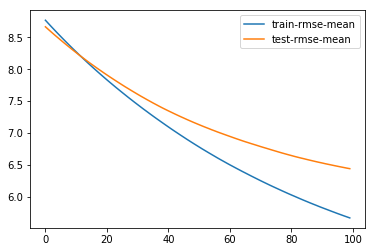

In [22]:
param_boost = {'max_depth':10, 'eta':0.01, 'silent':0, 'objective':'reg:linear', 'min_child_weight':1}
cvresult2 = xgb.cv(param_boost, dtrain, num_boost_round=100, nfold=5,
            metrics='rmse', shuffle=False)
plt.plot(cvresult2.index, cvresult2['train-rmse-mean'])
plt.plot(cvresult2.index, cvresult2['test-rmse-mean'])
plt.legend()

In [27]:
test = pd.read_csv('test.csv')
train_monthly.tail()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt,prev_mean_item_price,prev_min_item_price,prev_max_item_price
1609119,59,22164,2015,4,2.0,1.0,699.0,699.0,699.0
1609120,59,22164,2015,7,1.0,0.0,699.0,699.0,699.0
1609121,59,22167,2013,10,1.0,0.0,299.0,299.0,299.0
1609122,59,22167,2013,12,2.0,0.0,299.0,299.0,299.0
1609123,59,22167,2014,6,1.0,0.0,299.0,299.0,299.0


In [36]:
nov_2015 = pd.DataFrame( index = pd.date_range(start='2015-11-01', end='2015-11-30'))

In [39]:
test.join(nov_2015, how='outer')

,ID,shop_id,item_id
2015-11-01 00:00:00,NaN,NaN,NaN
2015-11-02 00:00:00,NaN,NaN,NaN
2015-11-03 00:00:00,NaN,NaN,NaN
2015-11-04 00:00:00,NaN,NaN,NaN
2015-11-05 00:00:00,NaN,NaN,NaN
2015-11-06 00:00:00,NaN,NaN,NaN
2015-11-07 00:00:00,NaN,NaN,NaN
2015-11-08 00:00:00,NaN,NaN,NaN
2015-11-09 00:00:00,NaN,NaN,NaN
2015-11-10 00:00:00,NaN,NaN,NaN
